# CDD 

<xarray.Dataset>
Dimensions:           (lat: 26, lon: 49)
Coordinates:
  * lat               (lat) float64 25.92 26.86 27.8 28.74 ... 47.59 48.53 49.48
  * lon               (lon) float64 235.0 236.2 237.5 ... 292.5 293.8 295.0
Data variables:
    cold_degree_days  (lat, lon) float32 ...
<xarray.Dataset>
Dimensions:                               (ensemble: 50, lat: 26, lon: 49)
Coordinates:
  * ensemble                              (ensemble) int64 0 1 2 3 ... 47 48 49
  * lat                                   (lat) float64 25.92 26.86 ... 49.48
  * lon                                   (lon) float64 235.0 236.2 ... 295.0
Data variables:
    days_below_0_ensemble_1991_2020       (ensemble, lat, lon) float32 ...
    days_below_0_ensemble_mean_1991_2020  (lat, lon) float32 ...
GRIDMET valid data points: 694
CESM2-LE valid data points: 694
Average Bias: -57.35952604309763
Difference valid data points: 694


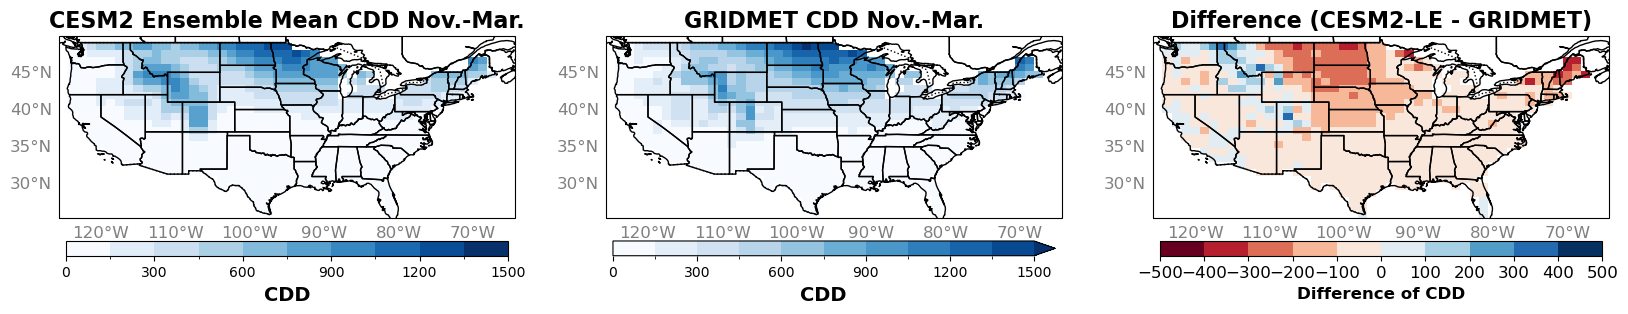

In [21]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the data from NetCDF file for the first dataset (GRIDMET)
ds_gridmet = xr.open_dataset('/home/shawn_preston/daysbelow0ensemble/bili_avg_gridmet_climatology_1991_2020.nc')
print(ds_gridmet)
# Load the data from NetCDF file for the second dataset (CESM2-LE GridMET)
ds_cesm2 = xr.open_dataset('/home/shawn_preston/daysbelow0ensemble/tavgdaysbelow0_1991_2020.nc')
print(ds_cesm2)
# Regrid ds_cesm2 to match ds_gridmet
ds_cesm2 = ds_cesm2.interp(lat=ds_gridmet.lat, lon=ds_gridmet.lon, method="linear")

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, ds_gridmet['lon'].values, ds_gridmet['lat'].values)

# Select the variable you want to plot for the first dataset (GRIDMET)
variable_to_plot_gridmet = ds_gridmet['cold_degree_days']

# Apply the mask to the variable for the first dataset (GRIDMET)
masked_data_gridmet = variable_to_plot_gridmet.where(mask.notnull())
print("GRIDMET valid data points:", masked_data_gridmet.count().values)

# Select the variable you want to plot for the second dataset (CESM2-LE GridMET)
variable_to_plot_cesm2 = ds_cesm2['days_below_0_ensemble_mean_1991_2020']

# Apply the mask to the variable for the second dataset (CESM2-LE GridMET)
masked_data_cesm2 = variable_to_plot_cesm2.where(mask.notnull())
print("CESM2-LE valid data points:", masked_data_cesm2.count().values)

# Calculate the difference between the two datasets
difference = masked_data_cesm2 - masked_data_gridmet

# Calculate the average bias
average_bias = difference.mean().values
print("Average Bias:", average_bias)

# Create a mask to filter out NaN values
mask_difference = difference.where(mask.notnull())
print("Difference valid data points:", mask_difference.count().values)

# Set up the map with Cartopy for the subplot
proj = ccrs.PlateCarree()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(ncols=3, figsize=(20, 10), subplot_kw={'projection': proj})

# Add state and country borders to all subplots
for ax in axes:
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-')

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlines = False
    gl.ylines = False

# Define levels and colormap for the plots
levels = np.linspace(0, 1500, 11)
cmap = plt.get_cmap('Blues')

# Plotting for CESM2-LE GridMET
contour1 = masked_data_cesm2.plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[0].set_title('CESM2 Ensemble Mean CDD Nov.-Mar.', fontweight = 'bold', fontsize =16)

# Plotting for GRIDMET
contour2 = masked_data_gridmet.plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[1].set_title('GRIDMET CDD Nov.-Mar.', fontweight= 'bold', fontsize = 16)


# Plotting and annotating the difference
if mask_difference.count() > 0:
    levels_diff = np.linspace(-500, 500, 11)
    contour3 = mask_difference.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels_diff, add_colorbar=False)
    axes[2].set_title('Difference (CESM2-LE - GRIDMET)', fontweight = 'bold', fontsize = 16)
    cbar3 = plt.colorbar(contour3, ax=axes[2], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
    cbar3.set_label('Difference of CDD', fontweight='bold', fontsize=12)
    cbar3.set_ticks(np.linspace(-500, 500, 11))
    cbar3.ax.tick_params(labelsize=12)  # Set font size for colorbar ticks

    # Annotate average bias
    #axes[2].text(1.1, 0.5, f'Average Bias:\n{average_bias:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='center')

else:
    print("No valid data points in difference to plot.")

# Add colorbars
cbar1 = plt.colorbar(contour1, ax=axes[0], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar1.set_ticks(np.arange(0, 1501, 300))
cbar1.set_label('CDD', fontweight='bold', fontsize=14)

cbar2 = plt.colorbar(contour2, ax=axes[1], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar2.set_ticks(np.arange(0, 1501, 300))
cbar2.set_label('CDD', fontweight='bold', fontsize=14)
#fig.text(0.1,0.16,'a', fontsize = 14, fontweight = 'bold')
#plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1CDD.png',dpi = 300, bbox_inches = 'tight')
#plt.suptitle('1991-2020 Climatology Difference', fontsize =20, y = .49)
plt.show()


# Last Day of SPRING FROST

<xarray.Dataset>
Dimensions:    (lon: 49, lat: 26)
Coordinates:
  * lon        (lon) float64 235.0 236.2 237.5 238.8 ... 291.2 292.5 293.8 295.0
  * lat        (lat) float64 25.92 26.86 27.8 28.74 ... 46.65 47.59 48.53 49.48
Data variables:
    dayofyear  (lat, lon) float64 ...
<xarray.Dataset>
Dimensions:                         (lat: 26, lon: 49, year: 30, ensemble: 50)
Coordinates:
  * lat                             (lat) float64 25.92 26.86 ... 48.53 49.48
  * lon                             (lon) float64 235.0 236.2 ... 293.8 295.0
  * year                            (year) int64 1991 1992 1993 ... 2019 2020
Dimensions without coordinates: ensemble
Data variables:
    last_frost_dates_ensemble       (ensemble, year, lat, lon) float64 ...
    last_frost_dates_ensemble_mean  (year, lat, lon) float64 ...
GRIDMET valid data points: 694
CESM2-LE valid data points: 694
Average Bias: -29.734509125840358


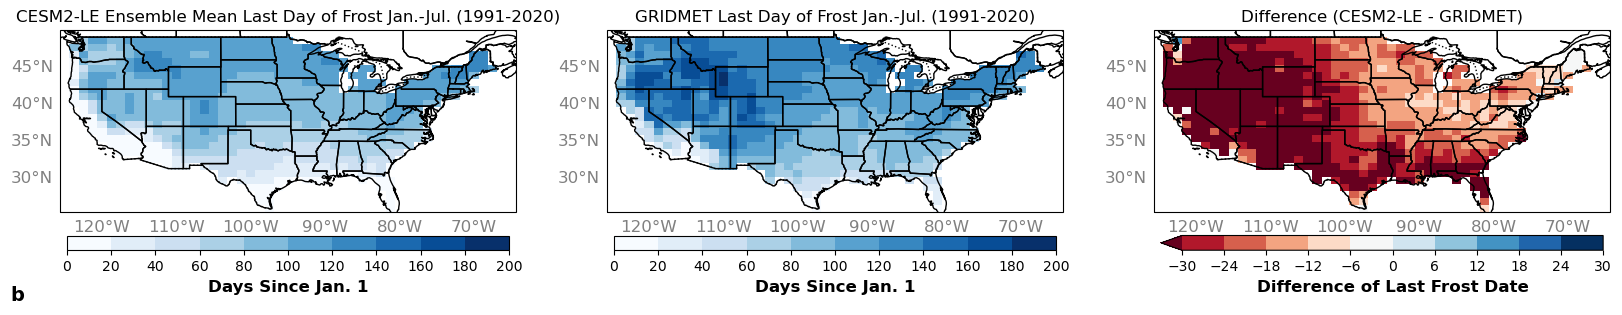

In [25]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the data from NetCDF file for the first dataset (GRIDMET)
ds_gridmet = xr.open_dataset('/home/shawn_preston/lastdayfrostensemble/average_last_frost_day_1991_2020.nc')
print(ds_gridmet)
# Load the data from NetCDF file for the second dataset (CESM2-LE GridMET)
ds_cesm2 = xr.open_dataset('/home/shawn_preston/lastdayfrostensemble/last_frost_1991_2020.nc')
print(ds_cesm2)
# Regrid ds_cesm2 to match ds_gridmet
ds_cesm2 = ds_cesm2.interp(lat=ds_gridmet.lat, lon=ds_gridmet.lon, method="linear")

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, ds_gridmet['lon'].values, ds_gridmet['lat'].values)

# Select the variable you want to plot for the first dataset (GRIDMET)
variable_to_plot_gridmet = ds_gridmet['dayofyear']

# Apply the mask to the variable for the first dataset (GRIDMET)
masked_data_gridmet = variable_to_plot_gridmet.where(mask.notnull())
print("GRIDMET valid data points:", masked_data_gridmet.count().values)

# Select the variable you want to plot for the second dataset (CESM2-LE GridMET)
variable_to_plot_cesm2 = ds_cesm2['last_frost_dates_ensemble_mean'].mean(dim='year')
                                                                

# Apply the mask to the variable for the second dataset (CESM2-LE GridMET)
masked_data_cesm2 = variable_to_plot_cesm2.where(mask.notnull())
print("CESM2-LE valid data points:", masked_data_cesm2.count().values)

# Calculate the difference between the two datasets
difference = masked_data_cesm2 - masked_data_gridmet

# Calculate the average bias, ignoring NaN values
average_bias = np.nanmean(difference)
print("Average Bias:", average_bias)

# Visualize the difference
# Set up the map with Cartopy for the subplot
proj = ccrs.PlateCarree()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(ncols=3, figsize=(20, 10), subplot_kw={'projection': proj})

# Add state and country borders to all subplots
for ax in axes:
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-')

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlines = False
    gl.ylines = False

# Define levels and colormap for the plots
levels = np.linspace(0, 200, 11)
cmap = plt.get_cmap('Blues')

# Plotting for CESM2-LE GridMET
contour1 = masked_data_cesm2.plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[0].set_title('CESM2-LE Ensemble Mean Last Day of Frost Jan.-Jul. (1991-2020)')

# Plotting for GRIDMET
contour2 = masked_data_gridmet.plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[1].set_title('GRIDMET Last Day of Frost Jan.-Jul. (1991-2020)')

# Plotting and annotating the difference
levels_diff = np.linspace(-30, 30, 11)
contour3 = difference.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels_diff, add_colorbar=False)
axes[2].set_title('Difference (CESM2-LE - GRIDMET)')
cbar3 = plt.colorbar(contour3, ax=axes[2], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar3.set_label('Difference of Last Frost Date', fontweight='bold', fontsize=12)
cbar3.set_ticks(np.linspace(-30, 30, 11))

# Annotate average bias
#axes[2].text(1.1, 0.5, f'Average Bias:\n{average_bias:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='center')

# Add colorbars
cbar1 = plt.colorbar(contour1, ax=axes[0], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar1.set_ticks(np.arange(0, 201, 20))
cbar1.set_label('Days Since Jan. 1', fontweight='bold', fontsize=12)

cbar2 = plt.colorbar(contour2, ax=axes[1], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar2.set_ticks(np.arange(0, 201, 20))
cbar2.set_label('Days Since Jan. 1', fontweight='bold', fontsize=12)
fig.text(0.1,0.16,'b', fontsize = 14, fontweight = 'bold')
plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1FROST.png',dpi = 300, bbox_inches = 'tight')
plt.show()


# GDD JANAPR

GRIDMET valid data points: 694
CESM2-LE valid data points: 694
Average Bias: -67.62873450989424
Difference valid data points: 694


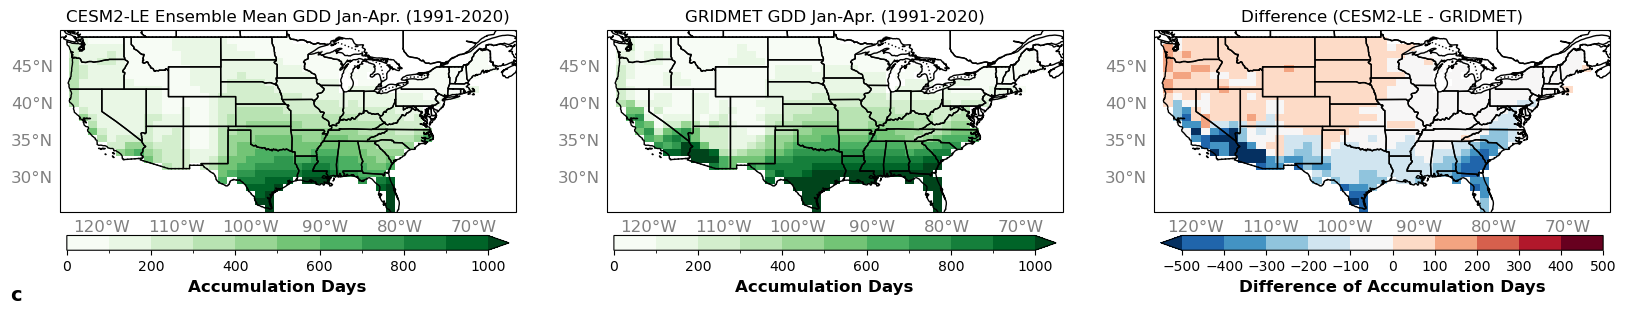

In [26]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the data from NetCDF file for the first dataset (GRIDMET)
ds_gridmet = xr.open_dataset('/home/shawn_preston/gddcesm2janapr/gdd_climatology_1991_2020.nc')

# Load the data from NetCDF file for the second dataset (CESM2-LE GridMET)
ds_cesm2 = xr.open_dataset('/home/shawn_preston/gddcesm2janapr/GDD_1991_2020.nc')

# Regrid ds_cesm2 to match ds_gridmet
ds_cesm2 = ds_cesm2.interp(lat=ds_gridmet.lat, lon=ds_gridmet.lon, method="linear")

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, ds_gridmet['lon'].values, ds_gridmet['lat'].values)

# Select the variable you want to plot for the first dataset (GRIDMET)
variable_to_plot_gridmet = ds_gridmet['growing_degree_days']

# Apply the mask to the variable for the first dataset (GRIDMET)
masked_data_gridmet = variable_to_plot_gridmet.where(mask.notnull())
print("GRIDMET valid data points:", masked_data_gridmet.count().values)

# Select the variable you want to plot for the second dataset (CESM2-LE GridMET)
variable_to_plot_cesm2 = ds_cesm2['gdd_ensemble_mean_1991_2020']

# Apply the mask to the variable for the second dataset (CESM2-LE GridMET)
masked_data_cesm2 = variable_to_plot_cesm2.where(mask.notnull())
print("CESM2-LE valid data points:", masked_data_cesm2.count().values)

# Calculate the difference between the two datasets
difference = masked_data_cesm2 - masked_data_gridmet

# Calculate the average bias
average_bias = difference.mean().values
print("Average Bias:", average_bias)

# Create a mask to filter out NaN values
mask_difference = difference.where(mask.notnull())
print("Difference valid data points:", mask_difference.count().values)

# Set up the map with Cartopy for the subplot
proj = ccrs.PlateCarree()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(ncols=3, figsize=(20, 10), subplot_kw={'projection': proj})

# Add state and country borders to all subplots
for ax in axes:
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-')

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlines = False
    gl.ylines = False

# Define levels and colormap for the plots
levels = np.linspace(0, 1000, 11)
cmap = plt.get_cmap('Greens')

# Plotting for CESM2-LE GridMET
contour1 = masked_data_cesm2.plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[0].set_title('CESM2-LE Ensemble Mean GDD Jan-Apr. (1991-2020)')

# Plotting for GRIDMET
contour2 = masked_data_gridmet.plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[1].set_title('GRIDMET GDD Jan-Apr. (1991-2020)')

# Plotting and annotating the difference
if mask_difference.count() > 0:
    levels_diff = np.linspace(-500, 500, 11)
    contour3 = mask_difference.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=levels_diff, add_colorbar=False)
    axes[2].set_title('Difference (CESM2-LE - GRIDMET)')
    cbar3 = plt.colorbar(contour3, ax=axes[2], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
    cbar3.set_label('Difference of Accumulation Days', fontweight='bold', fontsize=12)
    cbar3.set_ticks(np.linspace(-500, 500, 11))

    # Annotate average bias
    #axes[2].text(1.1, 0.5, f'Average Bias:\n{average_bias:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='center')

else:
    print("No valid data points in difference to plot.")

# Add colorbars
cbar1 = plt.colorbar(contour1, ax=axes[0], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar1.set_ticks(np.arange(0, 1001, 200))
cbar1.set_label('Accumulation Days', fontweight='bold', fontsize=12)

cbar2 = plt.colorbar(contour2, ax=axes[1], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar2.set_ticks(np.arange(0, 1001, 200))
cbar2.set_label('Accumulation Days', fontweight='bold', fontsize=12)
fig.text(0.1,0.16,'c', fontsize = 14, fontweight = 'bold')
plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1GDDJANAPR.png',dpi = 300, bbox_inches = 'tight')
plt.show()


# GDD JANSEP

GRIDMET valid data points: 694
CESM2-LE valid data points: 694
Average Bias: 183.70134793535004
Difference valid data points: 694


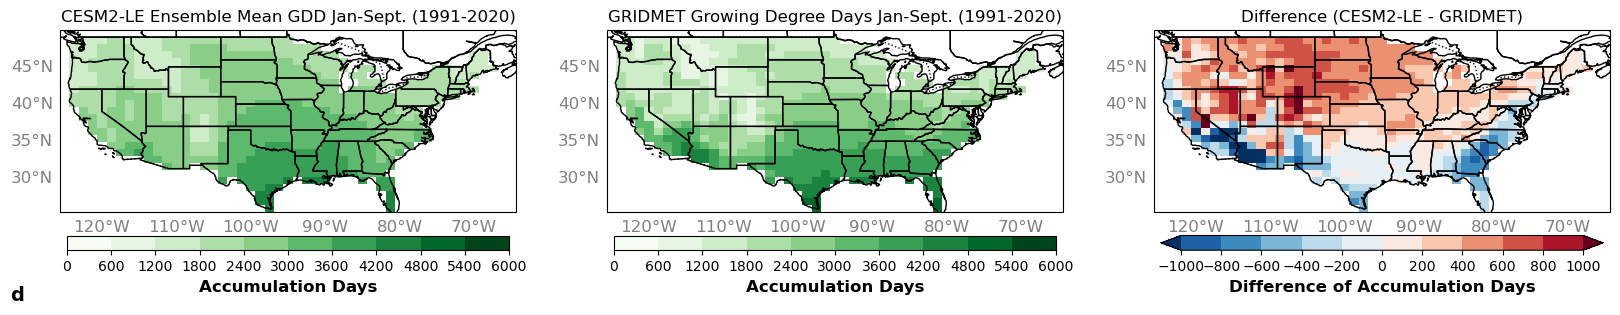

In [27]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the data from NetCDF file for the first dataset (GRIDMET)
ds_gridmet = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/gdd_climatology_1991_2020.nc')

# Load the data from NetCDF file for the second dataset (CESM2-LE GridMET)
ds_cesm2 = xr.open_dataset('/home/shawn_preston/gddcdesm2jansept/GDD_1991_2020.nc')

# Regrid ds_cesm2 to match ds_gridmet
ds_cesm2 = ds_cesm2.interp(lat=ds_gridmet.lat, lon=ds_gridmet.lon, method="linear")

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, ds_gridmet['lon'].values, ds_gridmet['lat'].values)

# Select the variable you want to plot for the first dataset (GRIDMET)
variable_to_plot_gridmet = ds_gridmet['growing_degree_days_sep']

# Apply the mask to the variable for the first dataset (GRIDMET)
masked_data_gridmet = variable_to_plot_gridmet.where(mask.notnull())
print("GRIDMET valid data points:", masked_data_gridmet.count().values)

# Select the variable you want to plot for the second dataset (CESM2-LE GridMET)
variable_to_plot_cesm2 = ds_cesm2['gdd_ensemble_mean_1991_2020']

# Apply the mask to the variable for the second dataset (CESM2-LE GridMET)
masked_data_cesm2 = variable_to_plot_cesm2.where(mask.notnull())
print("CESM2-LE valid data points:", masked_data_cesm2.count().values)

# Calculate the difference between the two datasets
difference = masked_data_cesm2 - masked_data_gridmet

# Calculate the average bias
average_bias = difference.mean().values
print("Average Bias:", average_bias)

# Create a mask to filter out NaN values
mask_difference = difference.where(mask.notnull())
print("Difference valid data points:", mask_difference.count().values)

# Set up the map with Cartopy for the subplot
proj = ccrs.PlateCarree()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(ncols=3, figsize=(20, 10), subplot_kw={'projection': proj})

# Add state and country borders to all subplots
for ax in axes:
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-')

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlines = False
    gl.ylines = False

# Define levels and colormap for the plots
levels = np.linspace(0, 6000, 11)
cmap = plt.get_cmap('Greens')

# Plotting for CESM2-LE GridMET
contour1 = masked_data_cesm2.plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[0].set_title('CESM2-LE Ensemble Mean GDD Jan-Sept. (1991-2020)')

# Plotting for GRIDMET
contour2 = masked_data_gridmet.plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[1].set_title('GRIDMET Growing Degree Days Jan-Sept. (1991-2020)')

# Plotting and annotating the difference
if mask_difference.count() > 0:
    levels_diff = np.linspace(-1000, 1000, 11)
    contour3 = mask_difference.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=levels_diff, add_colorbar=False)
    axes[2].set_title('Difference (CESM2-LE - GRIDMET)')
    cbar3 = plt.colorbar(contour3, ax=axes[2], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
    cbar3.set_label('Difference of Accumulation Days', fontweight='bold', fontsize=12)
    cbar3.set_ticks(np.linspace(-1000, 1000, 11))

    # Annotate average bias
    #axes[2].text(1.1, 0.5, f'Average Bias:\n{average_bias:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='center')

else:
    print("No valid data points in difference to plot.")

# Add colorbars
cbar1 = plt.colorbar(contour1, ax=axes[0], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar1.set_ticks(np.arange(0, 6001, 600))
cbar1.set_label('Accumulation Days', fontweight='bold', fontsize=12)

cbar2 = plt.colorbar(contour2, ax=axes[1], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar2.set_ticks(np.arange(0, 6001, 600))
cbar2.set_label('Accumulation Days', fontweight='bold', fontsize=12)
fig.text(0.1,0.16,'d', fontsize = 14, fontweight = 'bold')
plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1GDDJANSEP.png',dpi = 300, bbox_inches = 'tight')
plt.show()


# TMAX

<xarray.Dataset>
Dimensions:         (lat: 26, lon: 49)
Coordinates:
  * lat             (lat) float64 25.92 26.86 27.8 28.74 ... 47.59 48.53 49.48
  * lon             (lon) float64 235.0 236.2 237.5 238.8 ... 292.5 293.8 295.0
Data variables:
    days_above_34C  (lat, lon) float64 ...
<xarray.Dataset>
Dimensions:                       (ensemble: 50, lat: 26, lon: 49)
Coordinates:
  * ensemble                      (ensemble) int64 0 1 2 3 4 ... 45 46 47 48 49
  * lat                           (lat) float64 20.0 21.2 22.4 ... 48.8 50.0
  * lon                           (lon) float64 235.0 236.2 ... 293.8 295.0
Data variables:
    heat_ensemble_1991_2020       (ensemble, lat, lon) int64 ...
    heat_ensemble_mean_1991_2020  (lat, lon) float64 ...
GRIDMET valid data points: 694
CESM2-LE valid data points: 694
Average Bias: 8.330813763111992
Difference valid data points: 694


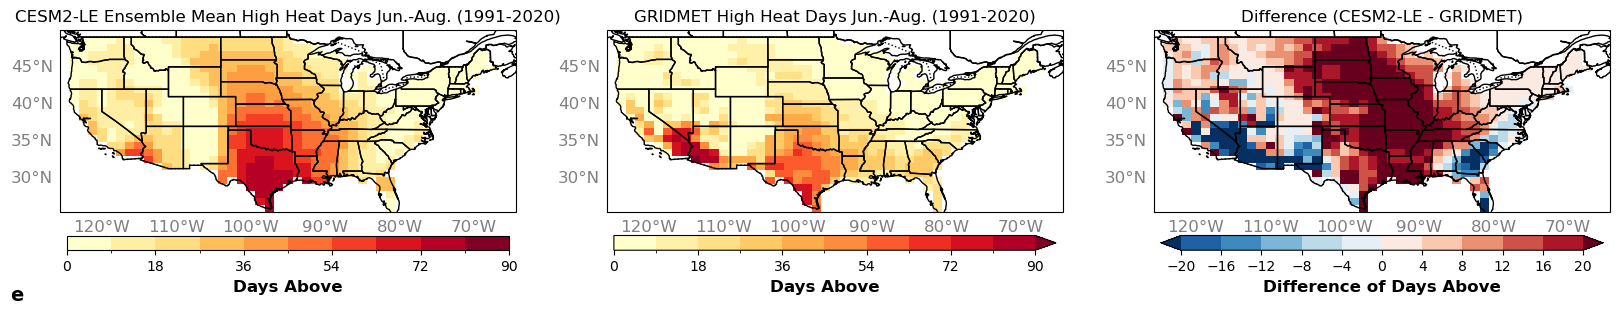

In [60]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the data from NetCDF file for the first dataset (GRIDMET)
ds_gridmet = xr.open_dataset('/home/shawn_preston/tmax34ensemble/days_above_34C_climatology_1991_2020.nc')
print(ds_gridmet)
# Load the data from NetCDF file for the second dataset (CESM2-LE GridMET)
ds_cesm2 = xr.open_dataset('/home/shawn_preston/tmax34ensemble/tmax1591_20.nc')
print(ds_cesm2)
# Regrid ds_cesm2 to match ds_gridmet
ds_cesm2 = ds_cesm2.interp(lat=ds_gridmet.lat, lon=ds_gridmet.lon, method="linear")

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, ds_gridmet['lon'].values, ds_gridmet['lat'].values)

# Select the variable you want to plot for the first dataset (GRIDMET)
variable_to_plot_gridmet = ds_gridmet['days_above_34C']

# Apply the mask to the variable for the first dataset (GRIDMET)
masked_data_gridmet = variable_to_plot_gridmet.where(mask.notnull())
print("GRIDMET valid data points:", masked_data_gridmet.count().values)

# Select the variable you want to plot for the second dataset (CESM2-LE GridMET)
variable_to_plot_cesm2 = ds_cesm2['heat_ensemble_mean_1991_2020']

# Apply the mask to the variable for the second dataset (CESM2-LE GridMET)
masked_data_cesm2 = variable_to_plot_cesm2.where(mask.notnull())
print("CESM2-LE valid data points:", masked_data_cesm2.count().values)

# Calculate the difference between the two datasets
difference = masked_data_cesm2 - masked_data_gridmet

# Calculate the average bias
average_bias = difference.mean().values
print("Average Bias:", average_bias)

# Create a mask to filter out NaN values
mask_difference = difference.where(mask.notnull())
print("Difference valid data points:", mask_difference.count().values)

# Set up the map with Cartopy for the subplot
proj = ccrs.PlateCarree()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(ncols=3, figsize=(20, 10), subplot_kw={'projection': proj})

# Add state and country borders to all subplots
for ax in axes:
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-')

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlines = False
    gl.ylines = False

# Define levels and colormap for the plots
levels = np.linspace(0, 90, 11)
cmap = plt.get_cmap('YlOrRd')

# Plotting for CESM2-LE GridMET
contour1 = masked_data_cesm2.plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[0].set_title('CESM2-LE Ensemble Mean High Heat Days Jun.-Aug. (1991-2020)')

# Plotting for GRIDMET
contour2 = masked_data_gridmet.plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[1].set_title('GRIDMET High Heat Days Jun.-Aug. (1991-2020)')

# Plotting and annotating the difference
if mask_difference.count() > 0:
    levels_diff = np.linspace(-20, 20, 11)
    contour3 = mask_difference.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=levels_diff, add_colorbar=False)
    axes[2].set_title('Difference (CESM2-LE - GRIDMET)')
    cbar3 = plt.colorbar(contour3, ax=axes[2], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
    cbar3.set_label('Difference of Days Above', fontweight='bold', fontsize=12)
    cbar3.set_ticks(np.linspace(-20, 20, 11))

    # Annotate average bias
    #axes[2].text(1.1, 0.5, f'Average Bias:\n{average_bias:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='center')

else:
    print("No valid data points in difference to plot.")

# Add colorbars
cbar1 = plt.colorbar(contour1, ax=axes[0], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar1.set_ticks(np.arange(0, 91, 18))
cbar1.set_label('Days Above', fontweight='bold', fontsize=12)

cbar2 = plt.colorbar(contour2, ax=axes[1], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar2.set_ticks(np.arange(0, 91, 18))
cbar2.set_label('Days Above', fontweight='bold', fontsize=12)
fig.text(0.1,0.16,'e', fontsize = 14, fontweight = 'bold')
plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1TMAX.png',dpi = 300, bbox_inches = 'tight')
plt.show()


# TMIN

<xarray.Dataset>
Dimensions:         (lat: 26, lon: 49)
Coordinates:
  * lat             (lat) float64 25.92 26.86 27.8 28.74 ... 47.59 48.53 49.48
  * lon             (lon) float64 235.0 236.2 237.5 238.8 ... 292.5 293.8 295.0
Data variables:
    days_above_15C  (lat, lon) float64 ...
<xarray.Dataset>
Dimensions:                        (ensemble: 50, lat: 26, lon: 49)
Coordinates:
  * ensemble                       (ensemble) int64 0 1 2 3 4 ... 45 46 47 48 49
  * lat                            (lat) float64 20.0 21.2 22.4 ... 48.8 50.0
  * lon                            (lon) float64 235.0 236.2 ... 293.8 295.0
Data variables:
    night_ensemble_1991_2020       (ensemble, lat, lon) int64 ...
    night_ensemble_mean_1991_2020  (lat, lon) float64 ...
GRIDMET valid data points: 694
CESM2-LE valid data points: 694
Average Bias: 18.405667206488534
Difference valid data points: 694


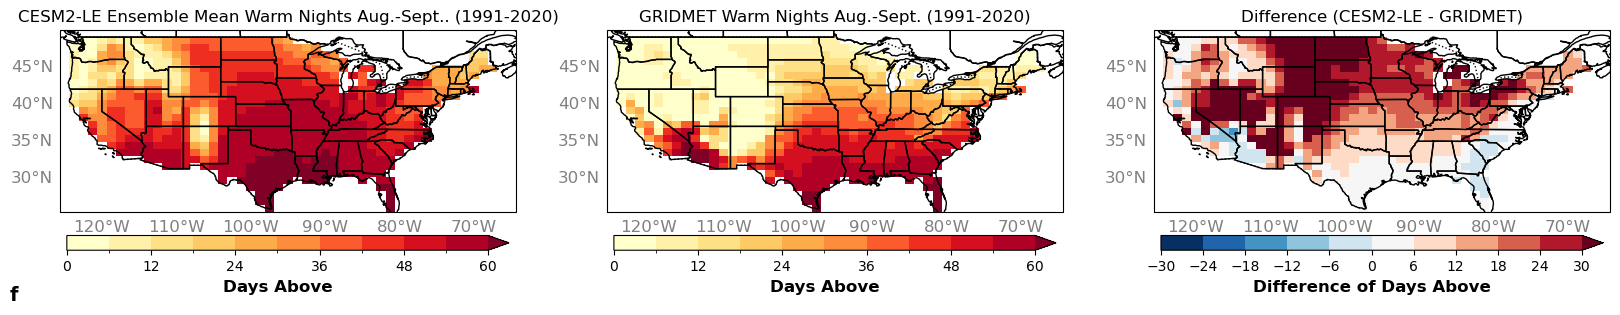

In [31]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the data from NetCDF file for the first dataset (GRIDMET)
ds_gridmet = xr.open_dataset('/home/shawn_preston/tmin15ensemble/days_above_15C_climatology_1991_2020.nc')
print(ds_gridmet)
# Load the data from NetCDF file for the second dataset (CESM2-LE GridMET)
ds_cesm2 = xr.open_dataset('/home/shawn_preston/tmin15ensemble/tmin1591_20.nc')
print(ds_cesm2)
# Regrid ds_cesm2 to match ds_gridmet
ds_cesm2 = ds_cesm2.interp(lat=ds_gridmet.lat, lon=ds_gridmet.lon, method="linear")

# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')

# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, ds_gridmet['lon'].values, ds_gridmet['lat'].values)

# Select the variable you want to plot for the first dataset (GRIDMET)
variable_to_plot_gridmet = ds_gridmet['days_above_15C']

# Apply the mask to the variable for the first dataset (GRIDMET)
masked_data_gridmet = variable_to_plot_gridmet.where(mask.notnull())
print("GRIDMET valid data points:", masked_data_gridmet.count().values)

# Select the variable you want to plot for the second dataset (CESM2-LE GridMET)
variable_to_plot_cesm2 = ds_cesm2['night_ensemble_mean_1991_2020']

# Apply the mask to the variable for the second dataset (CESM2-LE GridMET)
masked_data_cesm2 = variable_to_plot_cesm2.where(mask.notnull())
print("CESM2-LE valid data points:", masked_data_cesm2.count().values)

# Calculate the difference between the two datasets
difference = masked_data_cesm2 - masked_data_gridmet

# Calculate the average bias
average_bias = difference.mean().values
print("Average Bias:", average_bias)

# Create a mask to filter out NaN values
mask_difference = difference.where(mask.notnull())
print("Difference valid data points:", mask_difference.count().values)

# Set up the map with Cartopy for the subplot
proj = ccrs.PlateCarree()

# Create a figure and subplots with 1 row and 3 columns
fig, axes = plt.subplots(ncols=3, figsize=(20, 10), subplot_kw={'projection': proj})

# Add state and country borders to all subplots
for ax in axes:
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle='-')

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlines = False
    gl.ylines = False

# Define levels and colormap for the plots
levels = np.linspace(0, 60, 11)
cmap = plt.get_cmap('YlOrRd')

# Plotting for CESM2-LE GridMET
contour1 = masked_data_cesm2.plot(ax=axes[0], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[0].set_title('CESM2-LE Ensemble Mean Warm Nights Aug.-Sept.. (1991-2020)')

# Plotting for GRIDMET
contour2 = masked_data_gridmet.plot(ax=axes[1], transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, add_colorbar=False)
axes[1].set_title('GRIDMET Warm Nights Aug.-Sept. (1991-2020)')

# Plotting and annotating the difference
if mask_difference.count() > 0:
    levels_diff = np.linspace(-30, 30, 11)
    contour3 = mask_difference.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=levels_diff, add_colorbar=False)
    axes[2].set_title('Difference (CESM2-LE - GRIDMET)')
    cbar3 = plt.colorbar(contour3, ax=axes[2], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
    cbar3.set_label('Difference of Days Above', fontweight='bold', fontsize=12)
    cbar3.set_ticks(np.linspace(-30, 30, 11))

    # Annotate average bias
    #axes[2].text(1.1, 0.5, f'Average Bias:\n{average_bias:.2f}', transform=axes[2].transAxes, fontsize=12, verticalalignment='center')

else:
    print("No valid data points in difference to plot.")

# Add colorbars
cbar1 = plt.colorbar(contour1, ax=axes[0], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar1.set_ticks(np.arange(0, 61, 12))
cbar1.set_label('Days Above', fontweight='bold', fontsize=12)

cbar2 = plt.colorbar(contour2, ax=axes[1], orientation='horizontal', pad=0.03, aspect=30, shrink=0.97)
cbar2.set_ticks(np.arange(0, 61, 12))
cbar2.set_label('Days Above', fontweight='bold', fontsize=12)
fig.text(0.1,0.16,'f', fontsize = 14, fontweight = 'bold')
plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1TMIN.png',dpi = 300, bbox_inches = 'tight')
plt.show()


# CREATE FIGURE

/tmp/ipykernel_9592/1447165715.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)


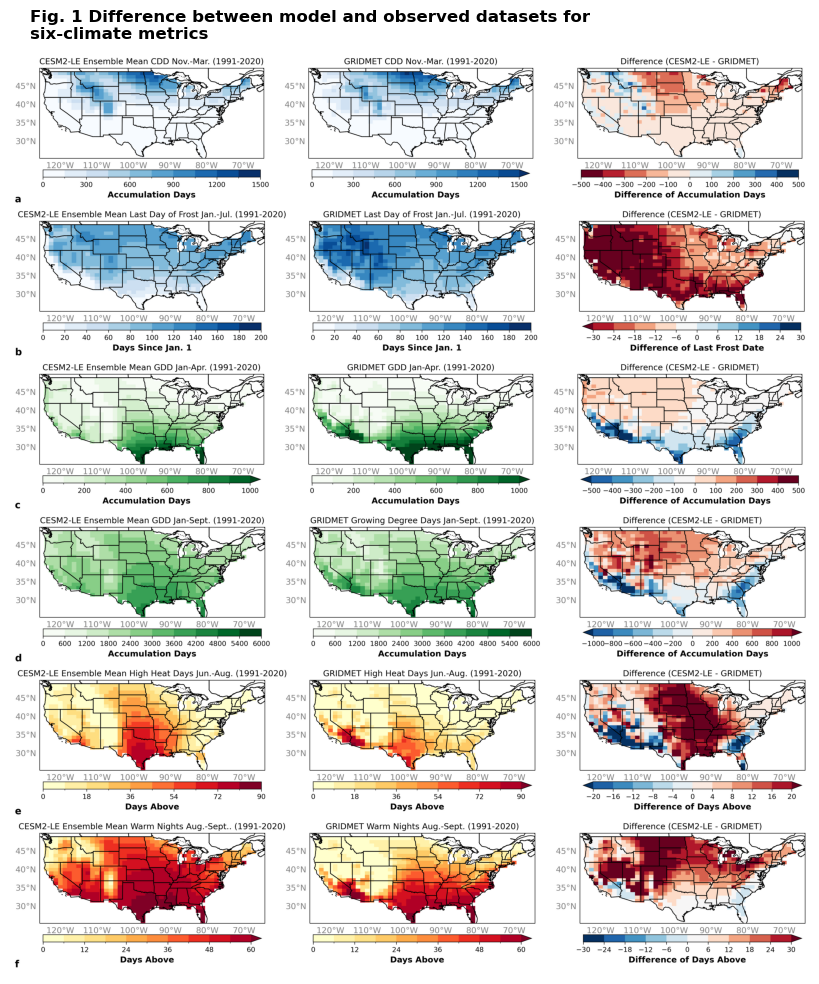

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Define the path to your images
image_dir = '/home/shawn_preston/CESM2PAPERFIGURES/'
image_names = ['FIG1CDD.png', 'FIG1FROST.png', 'FIG1GDDJANAPR.png', 'FIG1GDDJANSEP.png', 'FIG1TMAX.png', 'FIG1TMIN.png']
image_paths = [image_dir + name for name in image_names]

# Function to load and optionally resize images for zooming effect
def load_image(image_path, zoom_factor=1.5):
    img = Image.open(image_path)
    width, height = img.size
    new_width, new_height = int(width * zoom_factor), int(height * zoom_factor)
    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
    return resized_img

# Set up the figure and axes for a 6x1 grid (6 rows and 1 column)
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(10, 36))  # Adjust the figsize to better fit your needs

# Flatten the array of axes to make it easier to iterate over
axs = axs.flatten()

# Zoom factor (adjust this to zoom in or out)
zoom_factor = 2

# Loop through the list of image paths and axes to display each image
for ax, img_path in zip(axs, image_paths):
    resized_img = load_image(img_path, zoom_factor)
    ax.imshow(resized_img)
    ax.axis('off')  # Turn off axis labels

# Adjust layout to reduce white space between panels
plt.subplots_adjust(left=0.1, right=0.9, top=0.97, bottom=0.05, hspace=-.94, wspace=0.02)

# Add an overall title
plt.suptitle('Fig. 1 Difference between model and observed datasets for \nsix-climate metrics', x=0.12, ha='left', fontsize=12, y=0.65, fontweight='bold')

# Save the figure
plt.savefig('/home/shawn_preston/CESM2PAPERFIGURES/FIG1_zoomed.pdf', format = 'pdf',dpi=600, bbox_inches='tight')

# Show the figure
plt.show()
